# Evolution of "genetic architecture"


How does the contribution of rare alleles to additive genetic variance change as a function of time since an optimum shift?

This is a trial run of some new features in fwdpy, based on estimating frequency-vs-cumulative $V(A)$ following the methods in Sajnak et al (BioArxiv).

Model params:

* $N=1e3$ diploids
* 10 loci, $\rho = 100$ within loci, 50cM between loci
* Total mutation rate for the trait is $\mu=10^{-3}$, and this is parcelled out equally amongst loci
* $\sigma_\mu = 0.1$ per locus
* Gaussian stabilizing selection with $V(S) = 1$
* Optimum shifts from 0 to 0.5 at $10N$ generations, and we evolve for another $15N$ generations.
* Starting at the time of the optimum shift, we use linear regression to get the cumulative $V(A)$ plots every 10 generations.  The implementation is in C using the GSL.

Results based on 5,000 replicates of the 10-locus simulation.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
##Update fonts, etc, globally
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'legend.fontsize': 14})

## Plotting functions

In [3]:
def plot_adjacent(GEN):
    """
    Takes a list of sorted time points, and makes two plots.
    One plot is semilog, the other nativ scale.
    """
    fig=plt.figure(figsize=(20,20))
    gs=gridspec.GridSpec(2,1)
    semilog=plt.subplot(gs[0])
    natural=plt.subplot(gs[1])
    LT=['-', '--']
    LTI=0
    ##
    for gen_i in GEN:
        #gen_i = x100gen.get_group(gen)
        time=gen_i.iloc[0]['scaled_time']
        #gen_i.reset_index(inplace=True)
        totals=pd.Series([0.0]*2000) ##This will be used to sum across replicates
        reps=gen_i.groupby(['rep'])
        for rep in reps.groups:
            rep_i=reps.get_group(rep)
            rep_i.reset_index(inplace=True)
            rep_i.sort_values('freq')  #They should be sorted, but just in case
            temp=pd.Series([0.0]*2000)
            for i in range(len(rep_i.index)):
                row=rep_i.iloc[i]
                idx=int(row['freq']*2000.0)-1
                temp[idx]+=row['pss']
            totals=totals.add(temp.cumsum())   
        totals=totals.divide(float(len(x100.rep.unique())))
        semilog.semilogx(np.arange(1./2000.,1.+1./2000.,1./2000.),totals,
                 label='{0:0.2}'.format(time),
                linestyle=LT[LTI])
        natural.plot(np.arange(1./2000.,1.+1./2000.,1./2000.),totals,
                 label='{0:0.2}'.format(time),
                linestyle=LT[LTI])
        if LTI == 0:
            LTI=1
        else:
            LTI=0
    semilog.legend(ncol=2,loc='upper left',title="Time since optimum shift\n(units of N generations)")
    natural.legend(ncol=2,loc='lower right',title="Time since optimum shift\n(units of N generations)")
    semilog.set_xlabel("Derived mutation frequency (log scale)")
    semilog.set_ylabel("Cumulative %"+r'$V(A)$')
    natural.set_xlabel("Derived mutation frequency (natural scale)")
    natural.set_ylabel("Cumulative %"+r'$V(A)$')
    plt.tight_layout()

In [4]:
x=pd.read_hdf('cumVA.h5')

Since $N=1000$, there are 2,000 frequency bins.

## Let's look at a short time scale

How does this curve evolve for the first $0.1N$ generations after the optimum shift?

In [5]:
#Reduce data set to 100 gens after optimum shift
x100 = pd.DataFrame(x[x.generation <= 10100])
print(len(x100.index))

715267


In [6]:
x100.head()

,N,freq,generation,pss,rep
0,1000,0.0005,10000,0.007566,0
1,1000,0.0010,10000,0.010033,0
2,1000,0.0020,10000,0.002073,0
3,1000,0.0025,10000,0.000201,0
4,1000,0.0035,10000,0.009725,0


In [7]:
#Add time in units of N generations
x100['scaled_time']=x100.generation.subtract(10000.0).divide(1000.0)

In [8]:
x100gen = x100.groupby(['generation'])
print len(x100gen.rep.unique())

11


In [9]:
#Get a list of the above groups, sorted by generation
GEN=[]
for gen in x100gen.groups:
    gen_i=x100gen.get_group(gen)
    gen_i.reset_index(inplace=True)
    GEN.append(gen_i)
GEN=sorted(GEN,key=lambda x:x.generation.min())

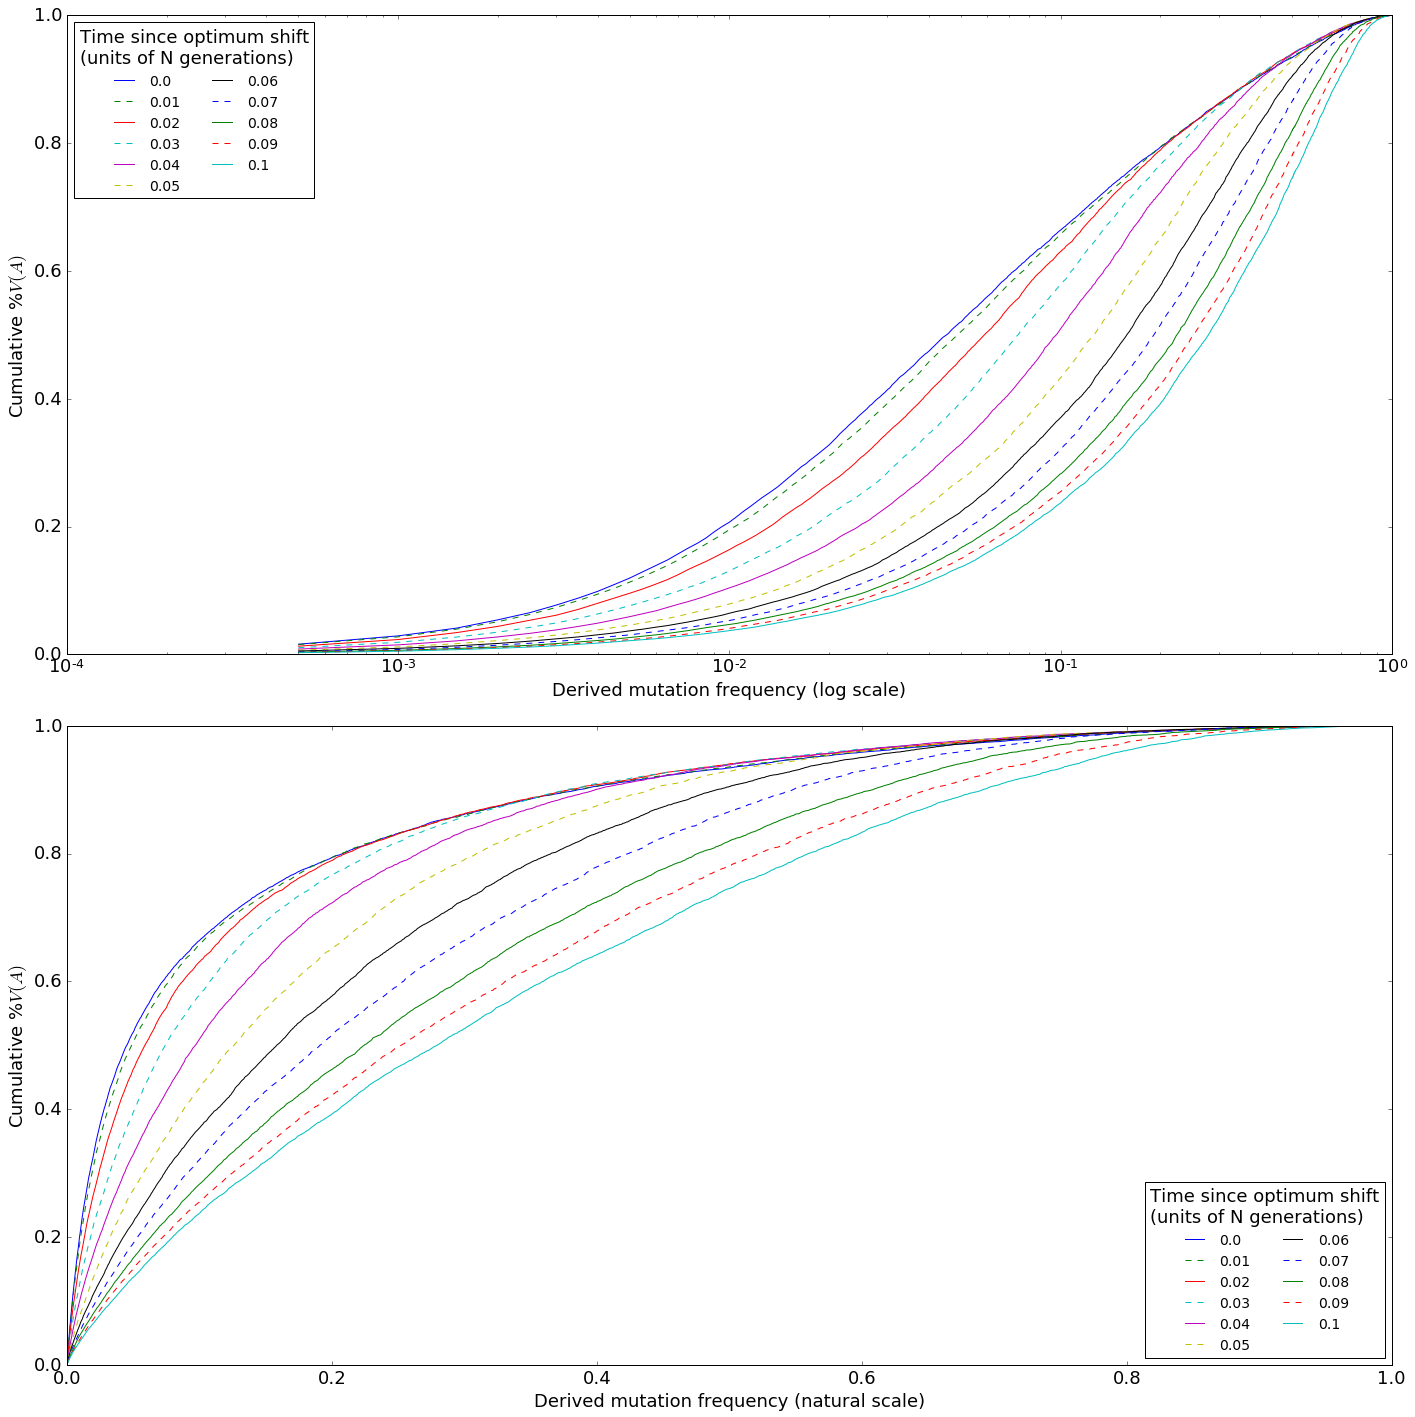

In [10]:
plot_adjacent(GEN)

## TL; DR

At time 0, RALE contribute more to VA.  The curve shifts right during adaptation, as intermediate-frequency variants begin to invade. 

## How long to return to equilibrium?

Let's redo the above, but only look every 2500 generations for 15N generations post-shift.

In [16]:
xLonger=pd.DataFrame(x[x.generation % 2500 == 0.0])

In [17]:
print(len(xLonger.index),len(x.index))

(432595, 93838473)


In [18]:
#Add time in units of N generations
xLonger['scaled_time']=xLonger.generation.subtract(10000.0).divide(1000.0)

In [19]:
#Get sorteg groups based on gen time
xLongerGen=xLonger.groupby(['generation'])
GEN=[]
for i in xLongerGen.groups:
    xi=xLongerGen.get_group(i)
    xi.reset_index(inplace=True)
    GEN.append(xi)
GEN=sorted(GEN,key = lambda x: x.generation.min())

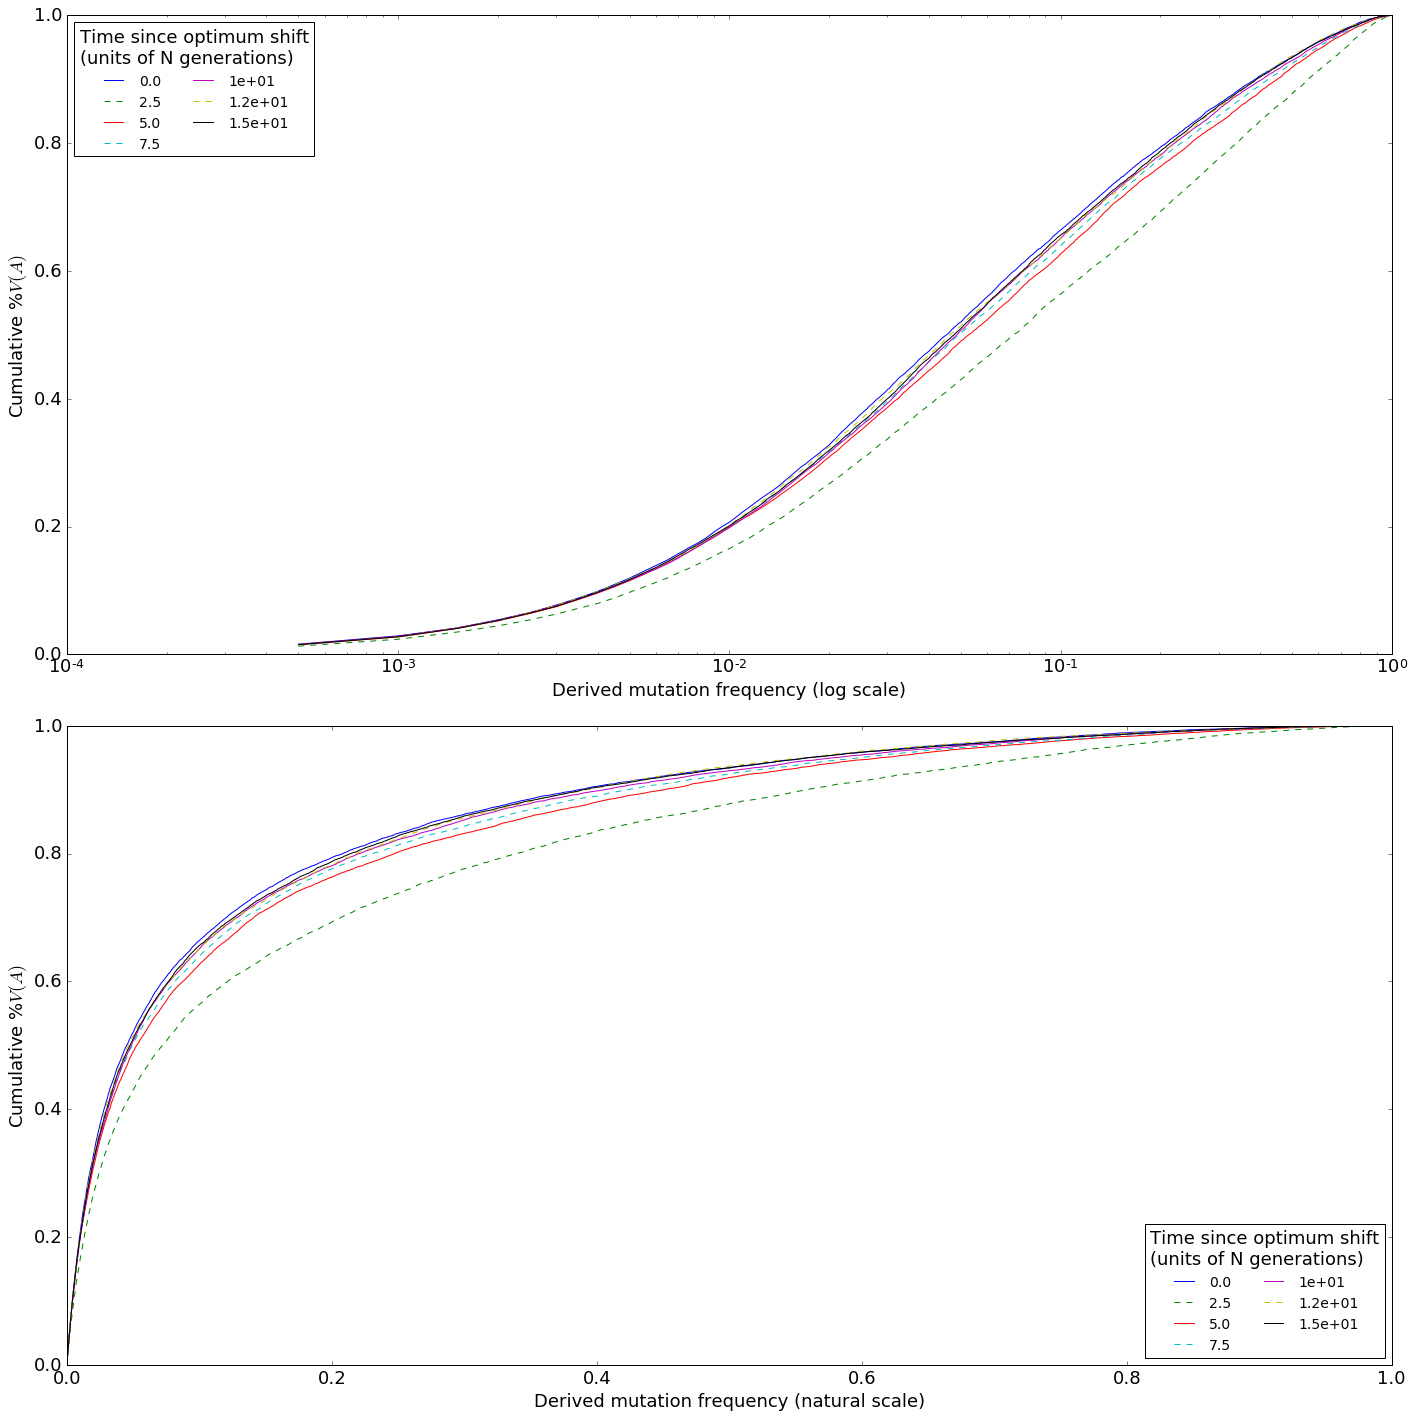

In [20]:
plot_adjacent(GEN)